<a href="https://colab.research.google.com/github/sladem-tox/PK_calcs/blob/main/2_CompartmentModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two-Compartment Model for IV bolus
`Page by Dr Slade Matthews, The University of Sydney, 2024`

For the two compartment model there are **two differential equations** that describe the disposition of the drug:


The first describes the change in concentration in the central compartment (C_1):




\begin{equation}
Equation 1:
\frac{dC_1}{dt} = - (k_{10} + k_{12}) C_1 + k_{21} C_2 + \frac{D}{V_1} \delta(t)
\end{equation}

The second equation describes the change in concentration in the peripheral compartment (C_2):

\begin{equation}
Equation 2:
\frac{dC_2}{dt} = k_{12} C_1 - k_{21} C_2
\end{equation}


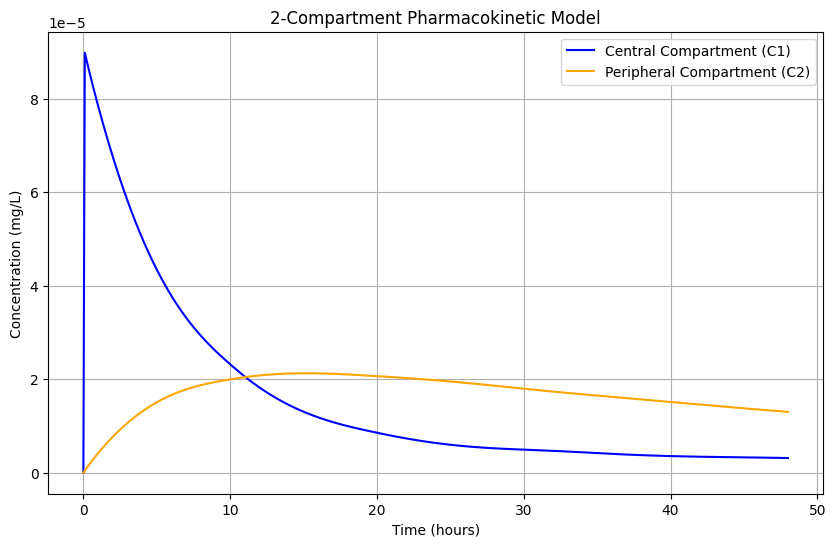

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the differential equations for the 2-compartment model
def two_compartment_model(t, C, k10, k12, k21, D, V1):
    C1, C2 = C  # C1 is central compartment, C2 is peripheral compartment
    dC1_dt = - (k10 + k12) * C1 + k21 * C2 + (D / V1 if t == 0 else 0)  # Dose only at t=0
    dC2_dt = k12 * C1 - k21 * C2
    return [dC1_dt, dC2_dt]

# Parameters
k10 = 0.1    # Elimination rate constant from central compartment
k12 = 0.05   # Transfer rate from central to peripheral compartment
k21 = 0.03   # Transfer rate from peripheral to central compartment
D = 100      # Dose (mg)
V1 = 10      # Volume of central compartment (L)

# Initial conditions: No drug in the system at the start
initial_conditions = [0, 0]

# Time span for the simulation
t_span = (0, 48)  # Simulate for 48 hours
t_eval = np.linspace(t_span[0], t_span[1], 500)  # Time points where solution is evaluated

# Solve the differential equations
solution = solve_ivp(two_compartment_model, t_span, initial_conditions, args=(k10, k12, k21, D, V1), t_eval=t_eval)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(solution.t, solution.y[0], label='Central Compartment (C1)', color='blue')
plt.plot(solution.t, solution.y[1], label='Peripheral Compartment (C2)', color='orange')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mg/L)')
plt.title('2-Compartment Pharmacokinetic Model')
plt.grid(True)
plt.legend()
plt.show()


The concentrations C_1(t) and C_2(t) can be determined using the analytical solutions (via Laplace transforms) to the differential equations of the 2-compartment model:

\begin{equation}
Equation 2: C_1(t) = A e^{-\alpha t} + B e^{-\beta t}
\end{equation}

\begin{equation}
Equation 3: C_2(t) = \frac{A \cdot k_{12}}{\alpha - k_{21}} e^{-\alpha t} + \frac{B \cdot k_{12}}{\beta - k_{21}} e^{-\beta t}
\end{equation}
Since we are usually most concerned with the concentration in the plasma, we primarily use the first equation, which solves for C_1.

In the code below we just call this plasma concentration. But we need several parameters in order to plot the concentration-time curve for an IV bolus with 2 compartments. Namely, we need: **D**:dose (mg), **V1** (volume of distribution of the central compartment (L), **alpha** (rate constant alpha (hr^-1), **beta** (rate constant beta (hr^-1) and **k_21** (transfer rate constant from periferal compartment back to central compartment hr^-1).

The terms A, B, alpha, and beta are derived during the integration process and are functions of parameters: k12, k21, kel, dose, and V1.

The macro-constants are based on the values of the micro-constants: kel (sometimes called k10), k12, k21.


\begin{equation}
\alpha = \frac{(k_{el} + k_{12} + k_{21}) + \sqrt{(k_{el} + k_{12} + k_{21})^2 - 4 \cdot k_{el} \cdot k_{21}}}{2}
\end{equation}

and

\begin{equation}
\beta = \frac{(k_{el} + k_{12} + k_{21}) - \sqrt{(k_{el} + k_{12} + k_{21})^2 - 4 \cdot k_{el} \cdot k_{21}}}{2}
\end{equation}

Since:
\begin{equation}
\alpha + \beta = (k_el + k_{21} + k_{12})
\end{equation}

And:
\begin{equation}
\alpha \cdot \beta = k_{el} \cdot k_{21}
\end{equation}
These formulae can be greatly simplified.

The alpha term determines the speed of movement during the initial absorption phase while the beta parameter determines the speed of the elimination phase.


The other two macro constants are A and B. These can be calculated once **alpha** and **beta** are calculated as above and also using **dose**, **V1** (voume of distribution in central compartment) and the microconstant **k_21**.

\begin{equation}
A = \frac{D \cdot (\alpha - k_{21})}{V_1 \cdot (\alpha - \beta)}
\end{equation}

\begin{equation}
B = \frac{D \cdot (k_{21} - \beta)}{V_1 \cdot (\alpha - \beta)}
\end{equation}
The A and B marco-constants determine how high the plasma concentration gets during the initial phase and the elimination phase, respectively.

# Determining A, B, α and β

Although we are going from micro-constants to macro-constants here, in reality the macro-constants are regularly determined first because they can be read off the integrated plasma-time curve (Equation 3) by a process of feathering. This is where the plasma-time curve is plotted on semi-logarithmic plot which highlights the two underlying functions. On this plot the change in plasma concentration follows two distinct straight line functions.

The steeper initial slope corresponds to α (distribution phase), and the shallower terminal slope corresponds to β (elimination phase).

After determining α and β, the intercepts of these extrapolated lines can be used to calculate A and B.

In [2]:
# Provide micro-rate values
# Here we use the values for Digoxin for a 70kg normal from Shargel.
k_el = 0.18
k_12 = 1.02
k_21 = 0.15
# Also provide dose and V1
D = 3.6*70       # Dose in mg
V1 = 0.78*70 # Volume of distribution in central compartment in L

In [3]:
# Calulate alpha and beta given the values of the micro-constants.
import numpy as np
# Calculate sum (alpha + beta)
sum_constants = k_el + k_12 + k_21
alpha_beta = k_el * k_21
# Calculate macroconstants alpha and beta
alpha = (sum_constants + np.sqrt((sum_constants**2)-(4*alpha_beta))) / 2
beta = (sum_constants - np.sqrt((sum_constants**2)-(4*alpha_beta))) / 2
#print(f"sum-constants{sum_constants: .2f}")
print(f"Alpha (α): {alpha:.4f} hr^-1")
print(f"Beta (β): {beta:.4f} hr^-1")

Alpha (α): 1.3297 hr^-1
Beta (β): 0.0203 hr^-1


In [4]:
# Calculate A and B given dose, V1 above, and having calculated alpha and beta.
A = (D * (alpha - k21)) / (V1 * (alpha - beta))
B = (D * (k21 - beta)) / (V1 * (alpha - beta))
print(f"A = {A:.2f}")
print(f"B = {B:.2f}")

A = 4.58
B = 0.03


In [5]:
# Possible values of A,B,alpha,beta that should give a good curve include
A = 20
B = 10
alpha = 4.1
beta = 0.5

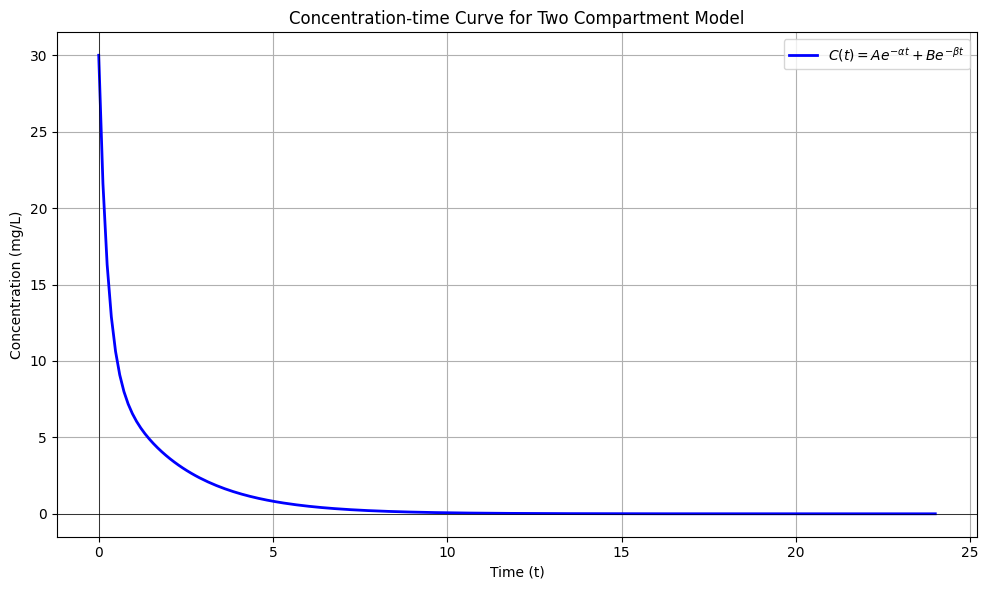

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create a set of values for t.
t = np.linspace(0, 24, 200)

# Define the function C1(t)
def C1(t, A, B, alpha, beta):
    return A * np.exp(-alpha * t) + B * np.exp(-beta * t)

# Calculate C1(t) values
C1_values = C1(t, A, B, alpha, beta)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, C1_values, label=r'$C(t) = A e^{-\alpha t} + B e^{-\beta t}$', color='blue', linewidth=2)

plt.title('Concentration-time Curve for Two Compartment Model')
plt.xlabel('Time (t)')
plt.ylabel('Concentration (mg/L)')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.legend()
plt.tight_layout()

# Show plot and parameter values in one neat location.
plt.show()
#print(f"Curve parameters: Dose = {D:.2f}, V1 = {V1:.2f}, A = {A:.2f}, B = {B:.2f}, alpha = {alpha:.2f}, beta = {beta:.2f}")


In [7]:
C1(0.1, A, B, alpha, beta)

22.785299247733526

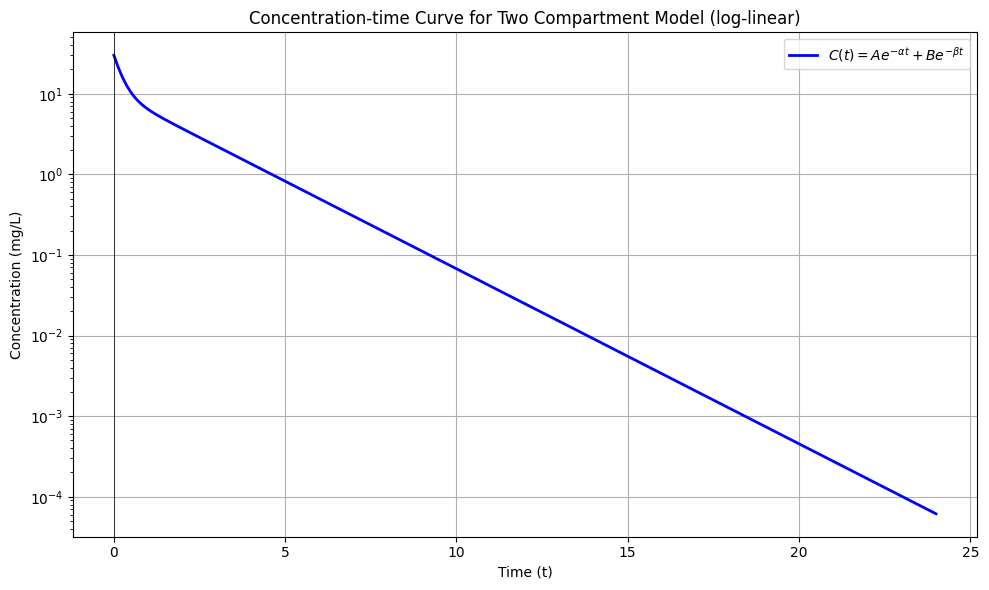

Curve parameters: Dose = 252.00, V1 = 54.60, A = 20.00, B = 10.00, alpha = 4.10, beta = 0.50


In [8]:
#Now present the plot on a log-linear scale to show deviation from a straight line.

t = np.linspace(0, 24, 200)

# Define the function C1(t)
def C1(t, A, B, alpha, beta):
    return A * np.exp(-alpha * t) + B * np.exp(-beta * t)

# Calculate C1(t) values
C1_values = C1(t, A, B, alpha, beta)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, C1_values, label=r'$C(t) = A e^{-\alpha t} + B e^{-\beta t}$', color='blue', linewidth=2)

plt.yscale('log')

# Adding labels and title
plt.title('Concentration-time Curve for Two Compartment Model (log-linear)')
plt.xlabel('Time (t)')
plt.ylabel('Concentration (mg/L)')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
print(f"Curve parameters: Dose = {D:.2f}, V1 = {V1:.2f}, A = {A:.2f}, B = {B:.2f}, alpha = {alpha:.2f}, beta = {beta:.2f}")

See also: https://www.youtube.com/watch?v=3ygsMD6DMFI&list=PLHZlPdW1nIJXUcE-igQhXuVpsahkgir18&index=9
